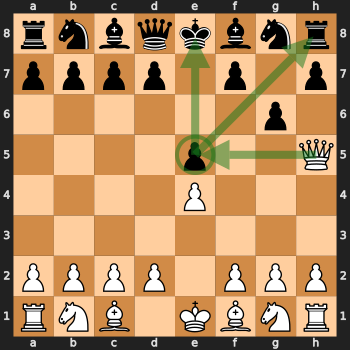

In [47]:
import io
import chess.pgn
import chess.svg

my_game = '''
1. e4 Nf6 2. e5 Nd5
3. c4 Nf4 4. d4 e6
5. Bxf4 d5 6. c5 Be7
7. Nc3 O-O 8. Nf3 b6
9. Na4 c6 10. Bd3 b5
11. Bh6 gxh6 12. Nc3 Na6
13. Qc2 Nb4 14. Bxh7+ Kg7
15. Qb1 Rh8 16. Bd3 f5
17. Ne2 Qa5 18. O-O Nxd3
19. Qxd3 Ba6 20. Qe3 b4
21. a3 bxa3 22. bxa3 Qb5
23. Rfe1 Rab8 24. Nf4 Qb3
25. Qd2 Rb5 26. Nxe6+ Kf7
27. Nf4 Rhb8 28. Rab1 Qxb1
29. Rxb1 Rxb1+ 30. Ne1 R1b2
31. Qe3 Rb1 32. Qg3 Rg8
33. Qh4 Rxe1# 0-1
'''

def final_position(pgn):
    pgnio = io.StringIO(pgn)
    g = chess.pgn.read_game(pgnio)
    pos = g.end()
    return chess.svg.board(pos.board(), arrows=pos.arrows(), size=350)

def board_at_move(pgn, n):
    pgnio = io.StringIO(pgn)
    g = chess.pgn.read_game(pgnio)
    for _ in range(n):
        g = g.next()
    return g.board()

final_position('1. e4 e5 2. Qh5 g6 { [%csl Ge5][%cal Gh5e5,Ge5h8,Ge5e8] } *')

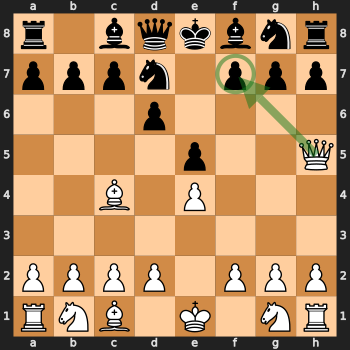

In [23]:
final_position('1. e4 e5 2. Qh5 d6 3. Bc4 Nd7 { [%csl Gf7][%cal Gh5f7] } *')

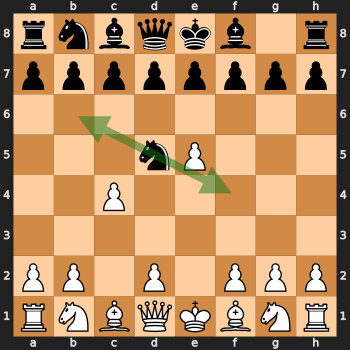

In [24]:
# Opening
final_position('1. e4 Nf6 2. e5 Nd5 3. c4 { [%cal Gd5f4,Gd5b6] } *')

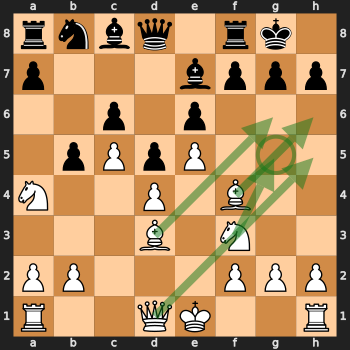

In [25]:
# End of opening
final_position('1. e4 Nf6 2. e5 Nd5 3. c4 Nf4 4. d4 e6 5. Bxf4 d5 6. c5 Be7 7. Nc3 O-O 8. Nf3 b6 9. Na4 c6 10. Bd3 b5 { [%csl Gg5][%cal Gf4h6,Gd3g6,Gd1h5,Gf3g5] } *')

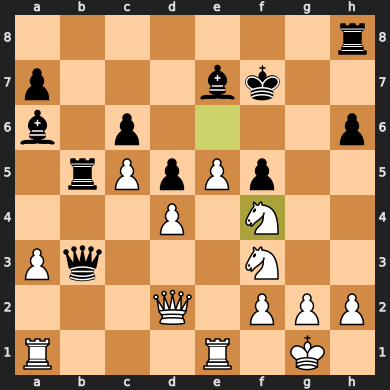

In [50]:
# Mid game
board_at_move(my_game, 27*2-1)

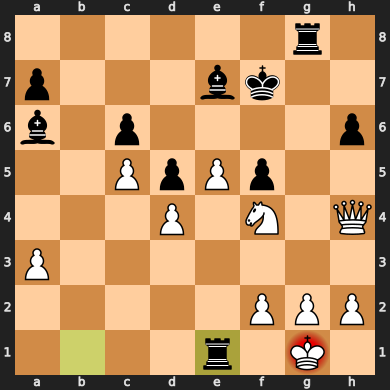

In [55]:
# End
board_at_move(my_game, 33*2)

In [27]:
# Game graph library
import igraph
import chess
import math


class Game():
    def __init__(self, game):
        self.game = game
 
    @property
    def moves_uci(self):
        res = []
        node = self.game
        while not node.is_end():
            node = node.next()
            res.append(node.uci())
        return res
    
    @property
    def moves_nodes(self):
        res = []
        node = self.game
        while not node.is_end():
            node = node.next()
            res.append(node)
        return res


class GamesGraph():
    def __init__(self):
        self.graph = igraph.Graph(directed=True)

    def add_move(self, start_fen, end_fen, uci):
        vs = self._ensure_vertex(start_fen)
        vt = self._ensure_vertex(end_fen)
        try:
            e = self.graph.es.find(_source=vs.index, _target=vt.index)
            e["count"] += 1
        except:
            e = self.graph.add_edge(vs, vt)
            e["uci"] = uci
            e["count"] = 1

    @property
    def start_node(self):
        return self.graph.vs.find(chess.STARTING_FEN)

    def _ensure_vertex(self, fen):
        try:
            return self.graph.vs.find(fen)
        except:
            v = self.graph.add_vertex(name=fen)
            v["fen"] = fen
            v["turn"] = chess.Board(fen).turn
            return v


def games_graph(games, max_moves):
    gr = GamesGraph()

    for game in games:
        start_fen = game.game.board().fen()
        for move in game.moves_nodes[:max_moves]:
            fen = move.board().fen()
            uci = move.uci()
            gr.add_move(start_fen, fen, uci)
            start_fen = fen

    return gr


def compute_edge_weights_uniform(vertex):
    all_count = vertex.degree(mode="out")
    for edge in vertex.out_edges():
        edge["prob"] = 1.0
        edge["weight"] = 0.0


def compute_edge_weights_counting(vertex, prob_ceiling):
    all_count = sum(map(lambda x: x["count"], vertex.out_edges()))
    for edge in vertex.out_edges():
        # Certainty doesn't exist... Let's put a probability ceiling (default 90%).
        prob = min(edge["count"] / all_count, prob_ceiling)
        edge["prob"] = prob
        edge["weight"] = -math.log(prob)


def compute_graph_weights(graph, black_uniform=False, white_uniform=False, prob_ceiling=0.9):
    # Compute the graph weights such that:
    # * The distance is the inverse of the probability to go from source to destination.
    # * Summation of two weights is the same as multiplying the probability.
    #
    # count: ranges from 1 to max; max = sum(out_edges["count"]).
    # prob: count / max_count; [0; 1]
    # weigth: -log(prob); [0; +inf] ~ [very_likely; unlikely]
    for vertex in graph.graph.vs:
        if vertex["turn"] == chess.WHITE and white_uniform:
            compute_edge_weights_uniform(vertex)
        elif vertex["turn"] == chess.BLACK and black_uniform:
            compute_edge_weights_uniform(vertex)
        else:
            compute_edge_weights_counting(vertex, prob_ceiling)

In [28]:
import chess.pgn
import io
import json

with open('playerx-games.json') as f:
    data = json.load(f)

games = []
for game in data:
    pgn = io.StringIO(game)
    games.append(Game(chess.pgn.read_game(pgn)))

black_games = [g for g in games if g.game.headers["Black"] == "playerx"]
len(games), len(black_games)

(542, 269)

In [29]:
# Load the evaluations
import chess

def load_evals_json(path):
    with open(path) as f:
        evaljs = json.load(f)

    evals = {}
    for pos in evaljs:
        evals[pos["fen"]] = pos["eval"]
    # add the initial position
    evals[chess.STARTING_FEN] = {
        "type": "cp",
        "value": 0,
    }
    return evals

# Returns [-1;1]
def rating(ev, fen):
    val = ev["value"]
    if ev["type"] == "cp":
        # Clamp to -300, +300. Winning a piece is enough.
        val = max(-300, min(300, val))
        return val / 300.0
    if val > 0: return 1.0
    if val < 0: return -1.0
    # This is mate, but is it white or black?
    b = chess.Board(fen)
    return 1.0 if b.turn == chess.WHITE else -1.0

# Returns [0;1], where 0 is min advantage, 1 is max for black.
def rating_black(ev, fen):
    return -rating(ev, fen) * 0.5 + 0.5

# Returns [0;1], where 0 is min advantage, 1 is max for black.
def rating_white(ev, fen):
    return rating(ev, fen) * 0.5 + 0.5


def compute_rating(evals, rating_fn):
    for fen in evals.keys():
        ev = evals[fen]
        evals[fen]["rating"] = rating_fn(ev, fen)


def update_graph_rating(g, evals):
    for v in g.graph.vs:
        v["rating"] = evals[v["fen"]]["rating"]

In [30]:
import chess
from functools import reduce

class Line():
    def __init__(self, end_node, moves, cost):
        self.end_node = end_node
        self.moves = moves
        self.cost = cost
    
    @property
    def moves_uci(self):
        return [e["uci"] for e in self.moves]
    
    @property
    def rating(self):
        return self.end_node["rating"]
    
    @property
    def probability(self):
        return reduce(lambda x, y: x*y, [e["prob"] for e in self.moves])
    
    @property
    def end_board(self):
        return chess.Board(self.end_node["fen"])

    @property
    def end_fen(self):
        return self.end_node["fen"]

    def __str__(self):
        return "{}: {} (prob={} rating={})".format(
            self.end_node["fen"],
            self.moves_uci,
            self.probability,
            self.rating,
        )
    
    def __repr__(self):
        return self.__str__()


def compute_line(graph, path):
    # Skip empty paths.
    if len(path) < 2:
        return None
    end_node = graph.graph.vs.find(path[-1])
    cost = 0
    moves = []
    for i in range(len(path) - 1):
        edge = graph.graph.es.find(_source=path[i], _target=path[i+1])
        cost += edge["weight"]
        moves.append(edge)
    return Line(end_node, moves, cost)


def best_lines(lines, min_rating=0.5):
    lines = filter(lambda x: x is not None, lines)
    return [
        l for l in sorted(lines, key=lambda x: x.cost)
        if l.rating > min_rating
    ]

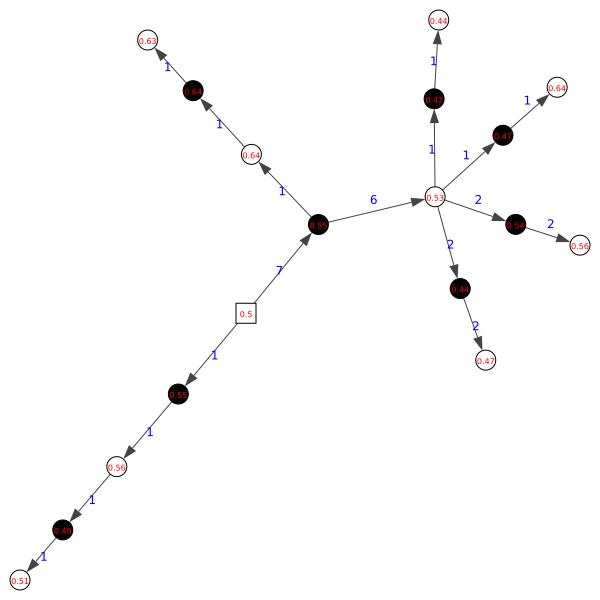

In [35]:
import igraph
import chess

g = games_graph(black_games[:8], 4)
fen_evals = load_evals_json('eval-black.json')
compute_rating(fen_evals, rating_white)
update_graph_rating(g, fen_evals)

style = {
    "edge_label": g.graph.es["count"],
    "edge_label_color": "blue",
    "vertex_label": ["{:.2}".format(x) for x in g.graph.vs["rating"]],
    "vertex_label_size": 8,
    "vertex_label_color": "red",
    "vertex_color": [("white" if x == chess.WHITE else "black") for x in g.graph.vs["turn"]],
    "vertex_shape": ["rectangle"] + ["circle" for _ in g.graph.vs][1:]
}
igraph.plot(g.graph, "graph-freq-eval.svg", **style)
igraph.plot(g.graph, **style)

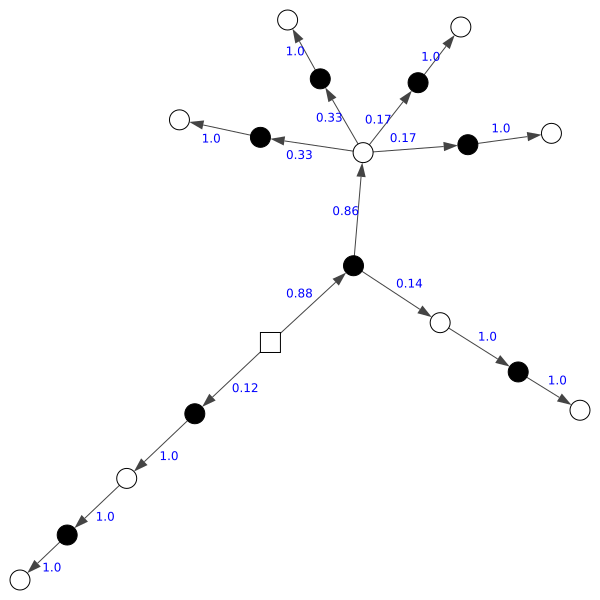

In [32]:
# Test weights without correcting for my moves equal probability, nor probability ceiling.
compute_graph_weights(g, prob_ceiling=1.0)


style = {
    "edge_label": ["{:.2}".format(x) for x in g.graph.es["prob"]],
    "edge_label_color": "blue",
    "vertex_color": [("white" if x == chess.WHITE else "black") for x in g.graph.vs["turn"]],
    "vertex_shape": ["rectangle"] + ["circle" for _ in g.graph.vs][1:]
}
igraph.plot(g.graph, "graph-prob.svg", **style)
igraph.plot(g.graph, **style)

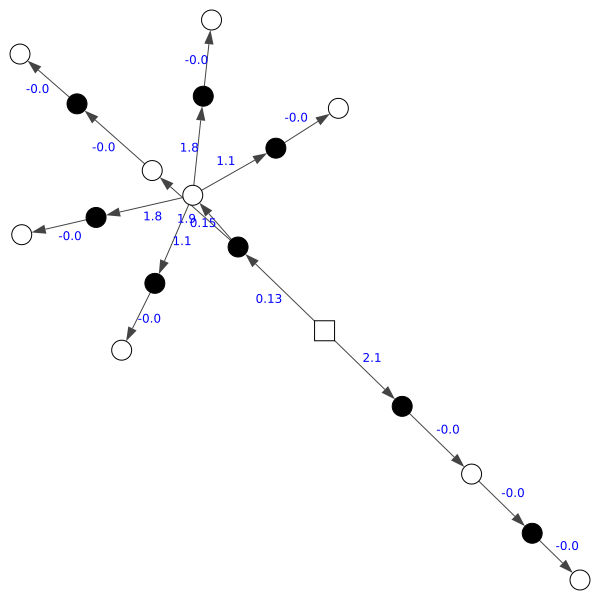

In [34]:
# Test weights without correcting for my moves equal probability, nor probability ceiling.
compute_graph_weights(g, prob_ceiling=1.0)

style = {
    "edge_label": ["{:.2}".format(x) for x in g.graph.es["weight"]],
    "edge_label_color": "blue",
    "vertex_color": [("white" if x == chess.WHITE else "black") for x in g.graph.vs["turn"]],
    "vertex_shape": ["rectangle"] + ["circle" for _ in g.graph.vs][1:]
}
igraph.plot(g.graph, "graph-weights-simple.svg", **style)
igraph.plot(g.graph, **style)